# Using PEFT with timm

`peft` allows us to train any model with LoRA as long as the layer type is supported. Since `Conv2D` is one of the supported layer types, it makes sense to test it on image models.

In this short notebook, we will demonstrate this with an image classification task using [`timm`](https://huggingface.co/docs/timm/index).

## Imports

Make sure that you have the latest version of `peft` installed. To ensure that, run this in your Python environment:
    
    python -m pip install --upgrade peft
    
Also, ensure that `timm` is installed:

    python -m pip install --upgrade timm

In [1]:
import timm
import torch
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

In [2]:
import peft
from datasets import load_dataset

In [3]:
torch.manual_seed(0)

## Loading the pre-trained base model

We use a small pretrained `timm` model, `PoolFormer`. Find more info on its [model card](https://huggingface.co/timm/poolformer_m36.sail_in1k).

In [4]:
model_id_timm = "timm/poolformer_m36.sail_in1k"

We tell `timm` that we deal with 3 classes, to ensure that the classification layer has the correct size.

In [5]:
model = timm.create_model(model_id_timm, pretrained=True, num_classes=3)

These are the transformations steps necessary to process the image.

In [6]:
transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))

## Data

For this exercise, we use the "beans" dataset. More details on the dataset can be found on [its datasets page](https://huggingface.co/datasets/beans). For our purposes, what's important is that we have image inputs and the target we're trying to predict is one of three classes for each image.

In [7]:
ds = load_dataset("beans")

Found cached dataset beans (/home/vinh/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
ds_train = ds["train"]
ds_valid = ds["validation"]

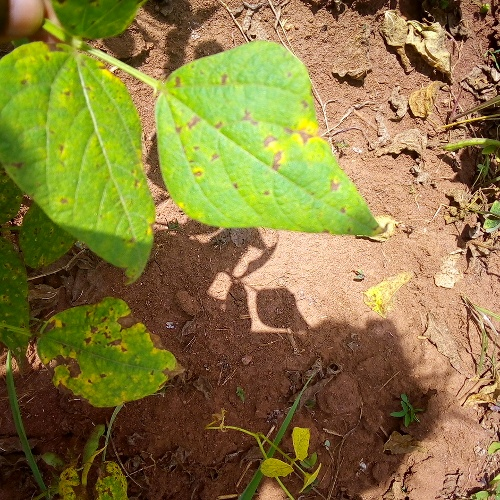

In [9]:
ds_train[0]["image"]

We define a small processing function which is responsible for loading and transforming the images, as well as extracting the labels.

In [10]:
def process(batch):
    x = torch.cat([transform(img).unsqueeze(0) for img in batch["image"]])
    y = torch.tensor(batch["labels"])
    return {"x": x, "y": y}

In [11]:
ds_train.set_transform(process)
ds_valid.set_transform(process)

In [12]:
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=32)
valid_loader = torch.utils.data.DataLoader(ds_valid, batch_size=32)

## Training

This is just a function that performs the train loop, nothing fancy happening.

In [13]:
def train(model, optimizer, criterion, train_dataloader, valid_dataloader, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            xb, yb = batch["x"], batch["y"]
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            lsm = torch.nn.functional.log_softmax(outputs, dim=-1)
            loss = criterion(lsm, yb)
            train_loss += loss.detach().float()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        valid_loss = 0
        correct = 0
        n_total = 0
        for batch in valid_dataloader:
            xb, yb = batch["x"], batch["y"]
            xb, yb = xb.to(device), yb.to(device)
            with torch.no_grad():
                outputs = model(xb)
            lsm = torch.nn.functional.log_softmax(outputs, dim=-1)
            loss = criterion(lsm, yb)
            valid_loss += loss.detach().float()
            correct += (outputs.argmax(-1) == yb).sum().item()
            n_total += len(yb)

        train_loss_total = (train_loss / len(train_dataloader)).item()
        valid_loss_total = (valid_loss / len(valid_dataloader)).item()
        valid_acc_total = correct / n_total
        print(f"{epoch=:<2}  {train_loss_total=:.4f}  {valid_loss_total=:.4f}  {valid_acc_total=:.4f}")

### Selecting which layers to fine-tune with LoRA

Let's take a look at the layers of our model. We only print the first 30, since there are quite a few:

In [14]:
[(n, type(m)) for n, m in model.named_modules()][:30]

[('', timm.models.metaformer.MetaFormer),
 ('stem', timm.models.metaformer.Stem),
 ('stem.conv', torch.nn.modules.conv.Conv2d),
 ('stem.norm', torch.nn.modules.linear.Identity),
 ('stages', torch.nn.modules.container.Sequential),
 ('stages.0', timm.models.metaformer.MetaFormerStage),
 ('stages.0.downsample', torch.nn.modules.linear.Identity),
 ('stages.0.blocks', torch.nn.modules.container.Sequential),
 ('stages.0.blocks.0', timm.models.metaformer.MetaFormerBlock),
 ('stages.0.blocks.0.norm1', timm.layers.norm.GroupNorm1),
 ('stages.0.blocks.0.token_mixer', timm.models.metaformer.Pooling),
 ('stages.0.blocks.0.token_mixer.pool', torch.nn.modules.pooling.AvgPool2d),
 ('stages.0.blocks.0.drop_path1', torch.nn.modules.linear.Identity),
 ('stages.0.blocks.0.layer_scale1', timm.models.metaformer.Scale),
 ('stages.0.blocks.0.res_scale1', torch.nn.modules.linear.Identity),
 ('stages.0.blocks.0.norm2', timm.layers.norm.GroupNorm1),
 ('stages.0.blocks.0.mlp', timm.layers.mlp.Mlp),
 ('stages.0.b

Most of these layers are not good targets for LoRA, but we see a couple that should interest us. Their names are `'stages.0.blocks.0.mlp.fc1'`, etc. With a bit of regex, we can match them easily.

Also, we should inspect the name of the classification layer, since we want to train that one too!

In [15]:
[(n, type(m)) for n, m in model.named_modules()][-5:]

[('head.global_pool.flatten', torch.nn.modules.linear.Identity),
 ('head.norm', timm.layers.norm.LayerNorm2d),
 ('head.flatten', torch.nn.modules.flatten.Flatten),
 ('head.drop', torch.nn.modules.linear.Identity),
 ('head.fc', torch.nn.modules.linear.Linear)]

    config = peft.LoraConfig(
        r=8,
        target_modules=r".*\.mlp\.fc\d|head\.fc",
    )

Okay, this gives us all the information we need to fine-tune this model. With a bit of regex, we match the convolutional layers that should be targeted for LoRA. We also want to train the classification layer `'head.fc'` (without LoRA), so we add it to the `modules_to_save`.

In [16]:
config = peft.LoraConfig(r=8, target_modules=r".*\.mlp\.fc\d", modules_to_save=["head.fc"])

Finally, let's create the `peft` model, the optimizer and criterion, and we can get started. As shown below, less than 2% of the model's total parameters are updated thanks to `peft`.

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
peft_model = peft.get_peft_model(model, config).to(device)
optimizer = torch.optim.Adam(peft_model.parameters(), lr=2e-4)
criterion = torch.nn.CrossEntropyLoss()
peft_model.print_trainable_parameters()

trainable params: 1,064,454 || all params: 56,467,974 || trainable%: 1.88505789139876


In [18]:
%time train(peft_model, optimizer, criterion, train_loader, valid_dataloader=valid_loader, epochs=10)

epoch=0   train_loss_total=1.2999  valid_loss_total=1.0624  valid_acc_total=0.4436
epoch=1   train_loss_total=1.0200  valid_loss_total=0.8906  valid_acc_total=0.7594
epoch=2   train_loss_total=0.8874  valid_loss_total=0.6894  valid_acc_total=0.8045
epoch=3   train_loss_total=0.7440  valid_loss_total=0.4797  valid_acc_total=0.8045
epoch=4   train_loss_total=0.6025  valid_loss_total=0.3419  valid_acc_total=0.8120
epoch=5   train_loss_total=0.4820  valid_loss_total=0.2589  valid_acc_total=0.8421
epoch=6   train_loss_total=0.3567  valid_loss_total=0.2101  valid_acc_total=0.8722
epoch=7   train_loss_total=0.2835  valid_loss_total=0.1385  valid_acc_total=0.9098
epoch=8   train_loss_total=0.1815  valid_loss_total=0.1108  valid_acc_total=0.9474
epoch=9   train_loss_total=0.1341  valid_loss_total=0.0785  valid_acc_total=0.9699
CPU times: user 4min 3s, sys: 36.3 s, total: 4min 40s
Wall time: 3min 32s


We get an accuracy of ~0.97, despite only training a tiny amount of parameters. That's a really nice result.

## Sharing the model through Hugging Face Hub

### Pushing the model to Hugging Face Hub

If we want to share the fine-tuned weights with the world, we can upload them to Hugging Face Hub like this:

In [19]:
user = "BenjaminB"  # put your user name here
model_name = "peft-lora-with-timm-model"
model_id = f"{user}/{model_name}"

In [20]:
peft_model.push_to_hub(model_id);

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.bin:   0%|          | 0.00/4.30M [00:00<?, ?B/s]

As we can see, the adapter size is only 4.3 MB. The original model was 225 MB. That's a very big saving.

### Loading the model from HF Hub

Now, it only takes one step to load the model from HF Hub. To do this, we can use `PeftModel.from_pretrained`, passing our base model and the model ID:

In [21]:
base_model = timm.create_model(model_id_timm, pretrained=True, num_classes=3)
loaded = peft.PeftModel.from_pretrained(base_model, model_id)

In [22]:
x = ds_train[:1]["x"]
y_peft = peft_model(x.to(device))
y_loaded = loaded(x)
torch.allclose(y_peft.cpu(), y_loaded)

True

### Clean up

Finally, as a clean up step, you may want to delete the repo.

In [23]:
from huggingface_hub import delete_repo

In [24]:
delete_repo(model_id)